<a href="https://colab.research.google.com/github/Grandediw/ml-algorthm/blob/main/LSTM_Transformer_Comparison_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# 1. Data Collection and Preprocessing

# Download the data
ticker = 'MSFT'
data = yf.download(ticker, start='2008-01-01', end='2022-10-01')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Feature Engineering
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_21'] = data['Close'].rolling(window=21).mean()
data['STD_7'] = data['Close'].rolling(window=7).std()
data['STD_21'] = data['Close'].rolling(window=21).std()
data['EMA_7'] = data['Close'].ewm(span=7, adjust=False).mean()
data['EMA_21'] = data['Close'].ewm(span=21, adjust=False).mean()
delta = data['Close'].diff(1)
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
time_period = 14
avg_gain = up.rolling(window=time_period).mean()
avg_loss = down.rolling(window=time_period).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100.0 - (100.0 / (1.0 + rs))
data.dropna(inplace=True)

# Define features and target
features = data.drop(['Close'], axis=1)
target = data['Close']

# Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences
def create_sequences(features, target, time_step):
    X, y = [], []
    for i in range(time_step, len(features)):
        X.append(features[i - time_step:i])
        y.append(target[i])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_features, scaled_target, time_step)

# Split data into training, validation, and test sets
# train_size = int(0.7 * len(X))
# val_size = int(0.15 * len(X))
# test_size = len(X) - train_size - val_size

# X_train = X[:train_size]
# y_train = y[:train_size]
# X_val = X[train_size:train_size + val_size]
# y_val = y[train_size:train_size + val_size]
# X_test = X[train_size + val_size:]
# y_test = y[train_size + val_size:]

from sklearn.model_selection import train_test_split

# Shuffle and split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 of remaining = 15% of total

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# 2. LSTM Model

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 3. Transformer Model

# Positional Encoding
def positional_encoding(seq_length, d_model):
    positions = np.arange(seq_length)[:, np.newaxis]
    dimensions = np.arange(d_model)[np.newaxis, :]
    angles = positions / np.power(10000, (2 * (dimensions // 2)) / np.float32(d_model))
    pos_encoding = np.zeros((seq_length, d_model))
    pos_encoding[:, 0::2] = np.sin(angles[:, 0::2])  # Apply sin to even indices
    pos_encoding[:, 1::2] = np.cos(angles[:, 1::2])  # Apply cos to odd indices
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x_ff = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation='relu')(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    return x

# Build Transformer Model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
pos_encoding = positional_encoding(X_train.shape[1], X_train.shape[2])
x = inputs + pos_encoding
for _ in range(3):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Train the Transformer model
transformer_history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate Models

def evaluate_model(model, X_data, y_data, target_scaler):
    predictions = model.predict(X_data)
    predictions_inverse = target_scaler.inverse_transform(predictions)
    y_data_inverse = target_scaler.inverse_transform(y_data)
    rmse = np.sqrt(mean_squared_error(y_data_inverse, predictions_inverse))
    mape = np.mean(np.abs((y_data_inverse - predictions_inverse) / y_data_inverse)) * 100
    return rmse, mape, predictions_inverse

# LSTM Evaluation
lstm_train_rmse, lstm_train_mape, lstm_train_predictions_inverse = evaluate_model(lstm_model, X_train, y_train, target_scaler)
lstm_val_rmse, lstm_val_mape, lstm_val_predictions_inverse = evaluate_model(lstm_model, X_val, y_val, target_scaler)
lstm_test_rmse, lstm_test_mape, lstm_test_predictions_inverse = evaluate_model(lstm_model, X_test, y_test, target_scaler)

# Transformer Evaluation
transformer_train_rmse, transformer_train_mape, transformer_train_predictions_inverse = evaluate_model(transformer_model, X_train, y_train, target_scaler)
transformer_val_rmse, transformer_val_mape, transformer_val_predictions_inverse = evaluate_model(transformer_model, X_val, y_val, target_scaler)
transformer_test_rmse, transformer_test_mape, transformer_test_predictions_inverse = evaluate_model(transformer_model, X_test, y_test, target_scaler)

# Print Results
print("LSTM Metrics:")
print(f"Train RMSE: {lstm_train_rmse}, Train MAPE: {lstm_train_mape}")
print(f"Validation RMSE: {lstm_val_rmse}, Validation MAPE: {lstm_val_mape}")
print(f"Test RMSE: {lstm_test_rmse}, Test MAPE: {lstm_test_mape}")

print("\nTransformer Metrics:")
print(f"Train RMSE: {transformer_train_rmse}, Train MAPE: {transformer_train_mape}")
print(f"Validation RMSE: {transformer_val_rmse}, Validation MAPE: {transformer_val_mape}")
print(f"Test RMSE: {transformer_test_rmse}, Test MAPE: {transformer_test_mape}")

# 5. Visualization

# Test Predictions
dates_test = data.index[-len(y_test):]
plt.figure(figsize=(14, 7))
plt.plot(dates_test, target_scaler.inverse_transform(y_test).flatten(), color='red', label='Actual')
plt.plot(dates_test, lstm_test_predictions_inverse.flatten(), color='green', label='LSTM Predictions')
plt.plot(dates_test, transformer_test_predictions_inverse.flatten(), color='blue', label='Transformer Predictions')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Training set: (2542, 60, 11), (2542, 1)
Validation set: (546, 60, 11), (546, 1)
Test set: (546, 60, 11), (546, 1)
Training set: (2542, 60, 11), (2542, 1)
Validation set: (546, 60, 11), (546, 1)
Test set: (546, 60, 11), (546, 1)
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - loss: 0.0167 - val_loss: 0.0054
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0024 - val_loss: 4.4100e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0019 - val_loss: 3.5005e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.0019 - val_loss: 3.7108e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0015 - val_loss: 4.5355e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0014 - val_loss: 4.8240e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.0012 - val_loss: 3.7842e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0012 - val_loss: 3.9975e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - l

In [ ]:
# Calculate residuals and confidence intervals for the LSTM model
lstm_train_residuals = target_scaler.inverse_transform(y_train) - lstm_train_predictions_inverse
lstm_residual_std = np.std(lstm_train_residuals)

lstm_upper_bound = lstm_test_predictions_inverse.flatten() + 1.96 * lstm_residual_std
lstm_lower_bound = lstm_test_predictions_inverse.flatten() - 1.96 * lstm_residual_std

# Calculate residuals and confidence intervals for the Transformer model
transformer_train_residuals = target_scaler.inverse_transform(y_train) - transformer_train_predictions_inverse
transformer_residual_std = np.std(transformer_train_residuals)

transformer_upper_bound = transformer_test_predictions_inverse.flatten() + 1.96 * transformer_residual_std
transformer_lower_bound = transformer_test_predictions_inverse.flatten() - 1.96 * transformer_residual_std


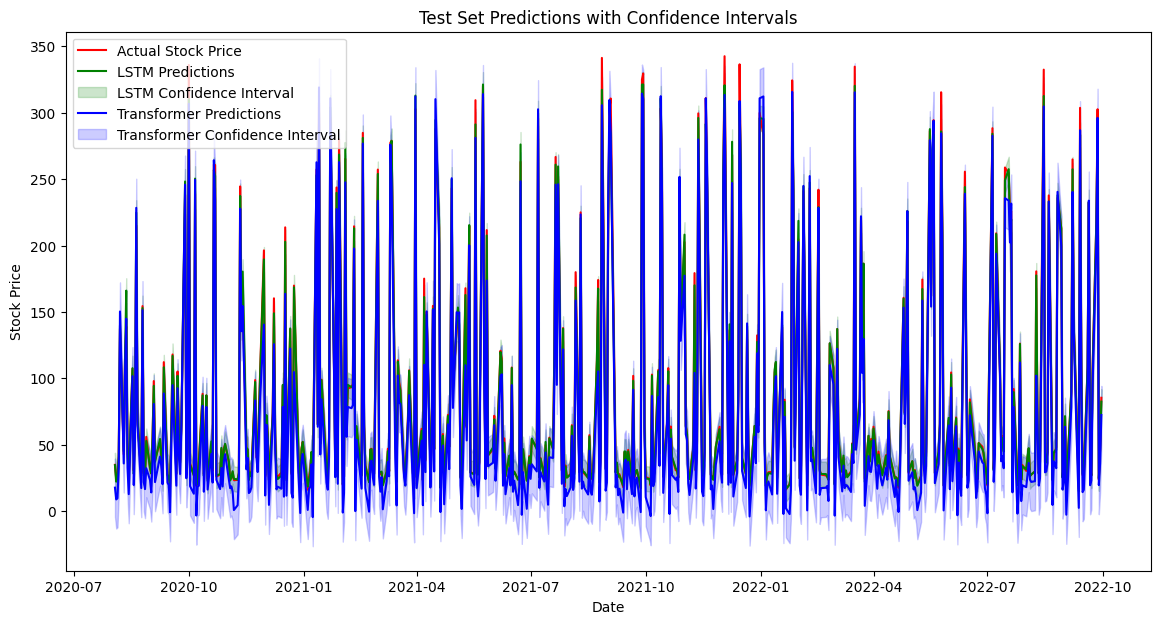

In [17]:
# Plot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(dates_test, target_scaler.inverse_transform(y_test).flatten(), color='red', label='Actual Stock Price')
plt.plot(dates_test, lstm_test_predictions_inverse.flatten(), color='green', label='LSTM Predictions')
plt.fill_between(dates_test, lstm_upper_bound, lstm_lower_bound, color='green', alpha=0.2, label='LSTM Confidence Interval')
plt.plot(dates_test, transformer_test_predictions_inverse.flatten(), color='blue', label='Transformer Predictions')
plt.fill_between(dates_test, transformer_upper_bound, transformer_lower_bound, color='blue', alpha=0.2, label='Transformer Confidence Interval')
plt.title('Test Set Predictions with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


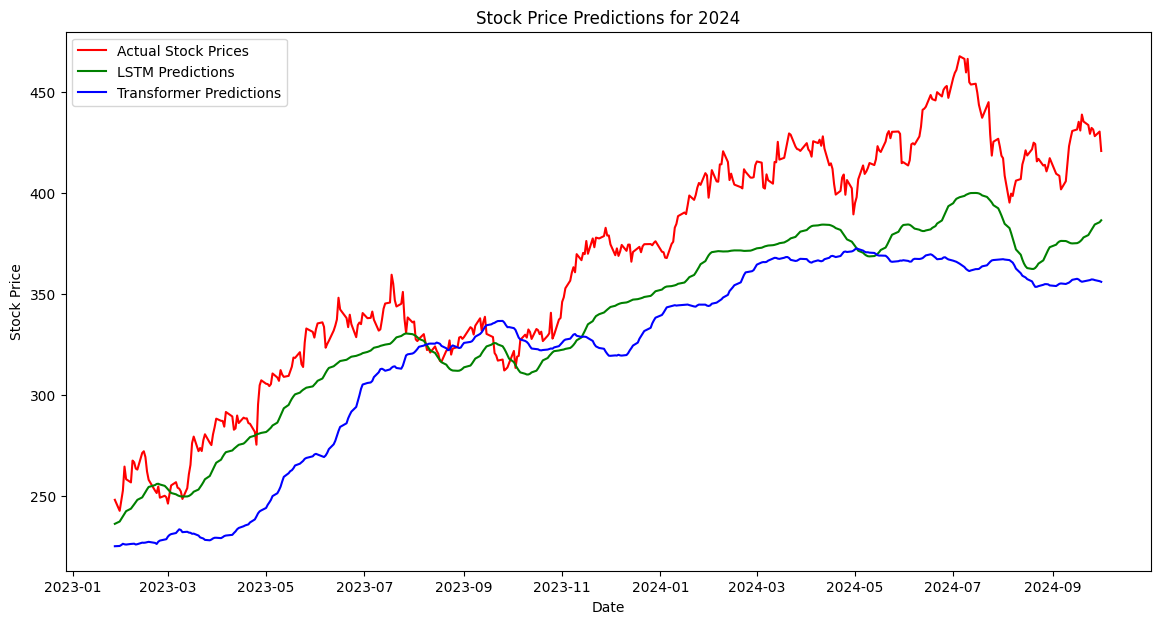

In [18]:
# Fetch data for the year 2024
data_2024 = yf.download(ticker, start='2022-10-02', end='2024-10-02')
data_2024 = data_2024[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add technical indicators to 2024 data
data_2024['MA_7'] = data_2024['Close'].rolling(window=7).mean()
data_2024['MA_21'] = data_2024['Close'].rolling(window=21).mean()
data_2024['STD_7'] = data_2024['Close'].rolling(window=7).std()
data_2024['STD_21'] = data_2024['Close'].rolling(window=21).std()
data_2024['EMA_7'] = data_2024['Close'].ewm(span=7, adjust=False).mean()
data_2024['EMA_21'] = data_2024['Close'].ewm(span=21, adjust=False).mean()
delta = data_2024['Close'].diff(1)
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
avg_gain = up.rolling(window=time_period).mean()
avg_loss = down.rolling(window=time_period).mean()
rs = avg_gain / avg_loss
data_2024['RSI'] = 100.0 - (100.0 / (1.0 + rs))
data_2024.dropna(inplace=True)

# Scale and create sequences for the 2024 data
scaled_features_2024 = feature_scaler.transform(data_2024.drop(['Close'], axis=1))
X_2024, _ = create_sequences(scaled_features_2024, np.zeros(len(scaled_features_2024)), time_step)

# Predict using LSTM and Transformer models
lstm_predictions_2024 = lstm_model.predict(X_2024)
transformer_predictions_2024 = transformer_model.predict(X_2024)

# Inverse transform the predictions
lstm_predictions_2024_inverse = target_scaler.inverse_transform(lstm_predictions_2024)
transformer_predictions_2024_inverse = target_scaler.inverse_transform(transformer_predictions_2024)

# Get the actual stock prices for 2024
actual_prices_2024 = data_2024['Close'].values[time_step:]

# Plot the actual and predicted stock prices for 2024
dates_2024 = data_2024.index[time_step:]
plt.figure(figsize=(14, 7))
plt.plot(dates_2024, actual_prices_2024, color='red', label='Actual Stock Prices')
plt.plot(dates_2024, lstm_predictions_2024_inverse.flatten(), color='green', label='LSTM Predictions')
plt.plot(dates_2024, transformer_predictions_2024_inverse.flatten(), color='blue', label='Transformer Predictions')
plt.title('Stock Price Predictions for 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()